# Anomaly Detection using Random Forest 

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import joblib

In [ ]:
# Loading Labelled Dataset
file_path = "/content/sample_data/Labelled_Data.csv"
df = pd.read_csv(file_path)

In [13]:
# Data exploration
print(df.info())
print(df["isFraud"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3684 entries, 0 to 3683
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            3684 non-null   int64  
 1   type            3684 non-null   object 
 2   amount          3684 non-null   float64
 3   nameOrig        3684 non-null   object 
 4   oldbalanceOrg   3684 non-null   float64
 5   newbalanceOrig  3684 non-null   float64
 6   nameDest        3684 non-null   object 
 7   oldbalanceDest  3684 non-null   float64
 8   newbalanceDest  3684 non-null   float64
 9   isFraud         3684 non-null   int64  
 10  isFlaggedFraud  3684 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 316.7+ KB
None
isFraud
0    3665
1      19
Name: count, dtype: int64


# There are only 19 fraud transactions, which is just 0.5% of the total data.

In [ ]:
# Encoding Categorical Features
le = LabelEncoder()
df['type'] = df['type'].astype(str)
le.fit(df['type'])  # Fitting only known categories
joblib.dump(le, "label_encoder.pkl")
df['type'] = le.transform(df['type'])

In [15]:
# Feature Engineering
df['balance_diffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_diffDest'] = df['oldbalanceDest'] - df['newbalanceDest']

In [ ]:
# Selecting Relevant Features
features = ["type", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "balance_diffOrig", "balance_diffDest"]
X = df[features]
y = df["isFraud"]

In [ ]:
# Handling Class Imbalance
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Increased sampling strategy
X_resampled, y_resampled = smote.fit_resample(X, y)

# Handling class imbalance is essential as fraud transactions are only 0.5% of the total data.

In [ ]:
# Standardizing Data
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
joblib.dump(scaler, "scaler.pkl")  # Save the scaler

['scaler.pkl']

In [ ]:
# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [ ]:
# Hyper-parameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 20}]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
rf = grid_search.best_estimator_

Best Parameters: {'class_weight': {0: 1, 1: 10}, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


# Hyper-parameter Tuning is used to determine the optimal parameters for our algorithm.

In [21]:
# Cross-validation
cv_scores = cross_val_score(rf, X_resampled, y_resampled, cv=5, scoring='roc_auc')
print("Cross-Validation ROC-AUC Scores:", cv_scores)
print("Mean ROC-AUC Score:", np.mean(cv_scores))

Cross-Validation ROC-AUC Scores: [0.99990335 0.99970633 0.99987327 0.99994782 0.99979126]
Mean ROC-AUC Score: 0.9998444047618829


# A 0.99 ROC-AUC score means the model is performing extremely well, and will distinguish correctly between the classes with a 99% chance.

In [22]:
# Predictions
y_proba = rf.predict_proba(X_test)[:, 1]

In [ ]:
# Find Optimal Threshold using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

y_pred = (y_proba > optimal_threshold).astype(int)

Optimal Threshold: 0.5447277891262943


In [24]:
# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       733
           1       0.99      1.00      0.99       367

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

Confusion Matrix:
 [[730   3]
 [  1 366]]
AUC-ROC Score: 0.9999107843173698


In [25]:
# Precision-Recall Curve and Average Precision Score
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap_score = average_precision_score(y_test, y_proba)
print("Average Precision Score:", ap_score)

Average Precision Score: 0.9998197494137551


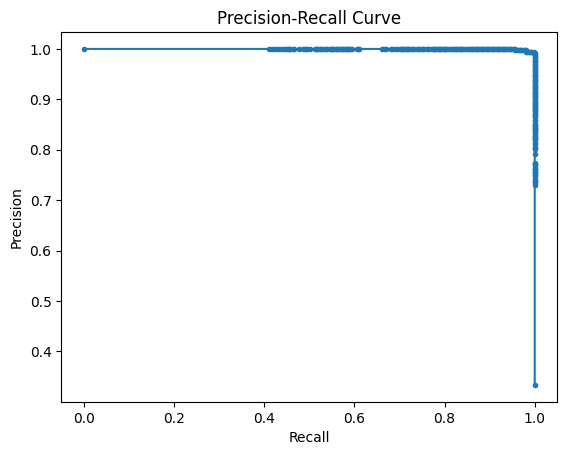

In [26]:
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# This graph indicates as there is an increase in Recall, the Precision drops. Although the model is good, there is still room for improvement.

In [27]:
# Feature Importance
feature_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("Feature Importance:\n", feature_importance)

Feature Importance:
 newbalanceOrig      0.317266
balance_diffOrig    0.183510
oldbalanceOrg       0.144003
oldbalanceDest      0.132313
type                0.082742
balance_diffDest    0.070124
amount              0.053396
newbalanceDest      0.016645
dtype: float64


In [ ]:
# Save model
joblib.dump(rf, "fraud_detection_rf_model.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [ ]:
# Load unlabeled dataset
file_path1 = "/content/sample_data/Unlabelled_Data.csv"
df_unlabeled = pd.read_csv(file_path1)

In [ ]:
# Load saved models
rf = joblib.load("fraud_detection_rf_model.pkl") # Load the Trained Model
le = joblib.load("label_encoder.pkl") # Load the Label Encoder
scaler = joblib.load("scaler.pkl")  # Load the scaler

In [ ]:
# Encoding Categorical Features
df_unlabeled['type'] = df_unlabeled['type'].astype(str)
known_categories = set(le.classes_)  # Get known categories
df_unlabeled['type'] = df_unlabeled['type'].apply(lambda x: x if x in known_categories else le.classes_[0])  # Assign first known category
df_unlabeled['type'] = le.transform(df_unlabeled['type'])

In [32]:
# Feature Engineering
df_unlabeled['balance_diffOrig'] = df_unlabeled['oldbalanceOrg'] - df_unlabeled['newbalanceOrig']
df_unlabeled['balance_diffDest'] = df_unlabeled['oldbalanceDest'] - df_unlabeled['newbalanceDest']

In [ ]:
# Selecting Relevant Features
X_unlabeled = df_unlabeled[features]

In [ ]:
# Standardizing Data
X_unlabeled = scaler.transform(X_unlabeled)

In [ ]:
# Predicting Fraud Cases
y_proba_unlabeled = rf.predict_proba(X_unlabeled)[:, 1]
y_pred_unlabeled = (y_proba_unlabeled > optimal_threshold).astype(int)

In [ ]:
# Add Predictions to the Dataset
df_unlabeled["isFraud_Predicted"] = y_pred_unlabeled

In [ ]:
# Save Results
df_unlabeled.to_csv("predicted_fraud_cases.csv", index=False)